In [1]:
import os
import math
import gzip
import pickle
from random import gauss
from itertools import product
from time import sleep
from datetime import datetime, timedelta, date
from urllib import request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
def plot_cv(df, train_idx, test_idx, i, n=5, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(n, 1, i)
    plt.axis([
        df.index.min(),
        df.index.max(),
        df.cl.min() * 0.99,
        df.cl.max() * 1.01
    ])
    plt.plot(df.iloc[train_idx].cl,
             ls='',
             marker='o',
             markersize=1,
             label='train')
    plt.plot(df.iloc[test_idx].cl,
             ls='',
             marker='o',
             markersize=1,
             label='test')
    plt.tight_layout()
    plt.legend()

## データ準備

In [3]:
with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
    df = pickle.load(f)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2022-03-01,BTCUSD,Sell,9,43179.5,MinusTick,876d94ec-9f6a-528f-9648-55c6133e19d6,20843.224215,9,0.000208
2022-03-01,BTCUSD,Sell,3,43179.5,ZeroMinusTick,b94b11dc-7747-50c5-9590-a732ab859939,6947.741405,3,0.000069
2022-03-01,BTCUSD,Sell,2,43179.5,ZeroMinusTick,2c833623-2598-57fa-8408-92900ffdc90f,4631.827603,2,0.000046
2022-03-01,BTCUSD,Sell,1,43178.5,MinusTick,ce18bf17-3535-534d-8745-bafb1267de27,2315.967437,1,0.000023
2022-03-01,BTCUSD,Sell,1,43178.0,MinusTick,29f8b6bf-066f-59c2-83b5-fe63a3739954,2315.994256,1,0.000023


In [4]:
#タイムバーの作成
FREQ = "15min"
time_bar = pd.DataFrame(columns=["op", "hi", "lo", "cl", "volume"])
time_bar.index.name = "timestamp"

ohlc = df["price"].resample(FREQ).ohlc()
volume = df["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)
ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo", "cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)

time_bar.head()

,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174


## 特徴量エンジニアリング

In [5]:
import talib

In [6]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df


In [7]:
calc_features(time_bar)

time_bar.to_pickle("df_features.pkl")
display(time_bar)

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174,169.260682,-29.1,-227.460682,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,99.180341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 22:45:00,45690.5,45800.0,45690.0,45786.0,7734788,73.42218,1.5,-70.42218,-168.148479,193.325447,...,0.995107,0.633786,0,0.383537,0.815266,8.0,84.732303,-133.0,10.846154,35.961090
2022-03-31 23:00:00,45780.5,45780.5,45650.0,45680.5,7040102,107.737695,18.35,-71.037695,-147.272226,206.441547,...,0.707763,0.000929,0,0.857388,0.730189,86.014286,80.261024,10.271429,5.826374,44.693847
2022-03-31 23:15:00,45680.0,45684.5,45589.0,45681.5,13943959,186.497663,87.55,-11.397663,-75.944683,269.445318,...,0.065495,-0.659277,0,0.534208,0.550943,52.8,-8.930590,54.842857,-0.157143,49.473831


## ラベリング

**opとclを比べて値段が上がったかどうかでラベリングする方法**

In [8]:
# # 目的変数の作成
# y = time_bar.cl / time_bar.op
# y = y.apply(lambda x: 1 if x > 1 else 0)
# y = y.shift(-1)
# time_bar["target"] = y
# time_bar.dropna(inplace=True)

# time_bar.to_pickle('df_features.pkl')

**固定時間ホライズン法によってラベリングする方法**

In [9]:
# h = 16  #固定時間ホライズンの設定(16/4=4時間)　15分足だから４で割ることで何時間分先の価格の予測かを求めれる。
# returns = (time_bar["cl"].diff(h).shift(-h)[:-h] /
#            time_bar["cl"][:-h]).rename('r')


# thre_r = 0.003
# labels_static = returns.apply(lambda x: x / abs(x) if abs(x) > thre_r else 0)
# #ラベルが分散するように手動で調整したが、のちに調整も自動化したい！
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(2,3,1)
# bins = np.linspace(-1, 1, 10)
# ax.hist(labels_static, bins, label=f'labels_static')
# ax.legend(loc='upper left')

# time_bar["target"] = labels_static
# time_bar.dropna(inplace=True)

# time_bar.to_pickle('df_features.pkl')



**richmanのリターンによるラベリングする方法**

毎時刻、この執行方法でトレードした場合の累積リターン


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

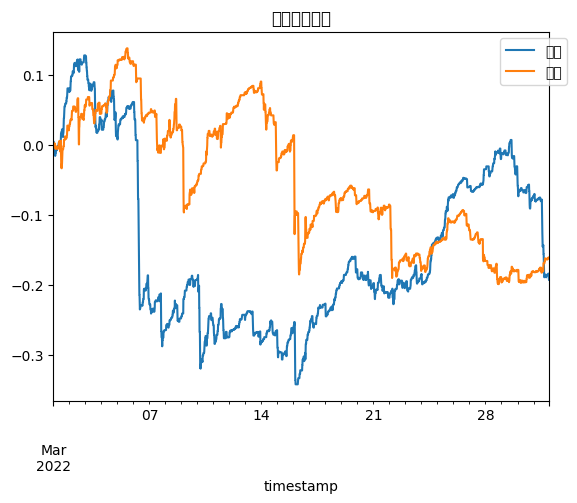

In [10]:
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
# fee = df['fee'] # maker手数料　一旦０で計算するが、richmanはdfにtimpstampに応じて変わるようにfeeを組み込んでいる。
fee = 0

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips) > (df['lo'].shift(-1) / pips)).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips) < (df['hi'].shift(-1) / pips)).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)


print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

Text(0.5, 1.0, 'fet')

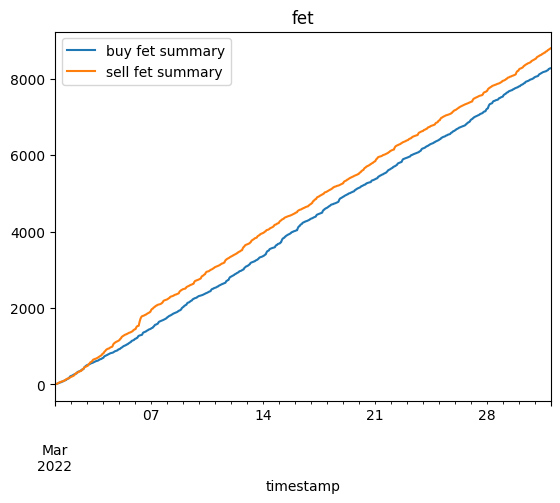

In [11]:
df["buy_fet"].cumsum().plot(label="buy fet summary")
df["sell_fet"].cumsum().plot(label="sell fet summary")
plt.legend()
plt.title("fet")

### 特徴量について調べる。

In [12]:
import seaborn as sns
time_bar.head()
# sns.heatmap(time_bar, square=True)

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174,169.260682,-29.1,-227.460682,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,99.180341


In [13]:
#以下のコードでは学習に使う特徴量カラムを指定する。
features =sorted([
    
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


モデルの生成・学習

In [14]:
df = pd.read_pickle('df_features.pkl')
df = df.dropna()

df.head()

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 22:00:00,43868.0,43868.0,43774.0,43840.0,4127124,222.605745,70.3,-82.005745,72.536391,-9.417522,...,0.402692,-0.362494,0,0.522806,0.862698,83.157143,82.122515,-10.8,7.227473,76.152873
2022-03-01 22:15:00,43840.0,43960.0,43840.0,43945.5,6538919,142.120738,-9.3,-160.720738,4.971313,-79.777682,...,0.192906,-0.557421,0,0.809185,0.866785,-13.185714,82.101170,-106.885714,7.207692,75.710369
2022-03-01 22:30:00,43945.5,44169.5,43939.5,44150.0,17811845,115.528242,-135.0,-385.528242,-113.817049,-213.001702,...,0.025228,-0.689043,0,0.327546,0.890181,-173.871429,83.782552,-293.2,9.179121,125.264121
2022-03-01 22:45:00,44150.0,44231.0,44058.5,44158.0,9410449,120.633162,-152.55,-425.733162,-170.944514,-282.832238,...,-0.075230,-0.758299,0,0.417686,0.901287,-114.042857,86.710757,-340.242857,17.400000,136.591581
2022-03-01 23:00:00,44158.0,44262.5,44078.0,44125.5,7828911,129.975116,-126.45,-382.875116,-170.749582,-291.326932,...,-0.062600,-0.749985,0,0.352744,0.917209,-42.685714,87.190608,-307.6,20.378022,128.212558


In [15]:
# #データを訓練用と検証用に分ける
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df[features],df["target"])

In [16]:
# from sklearn.ensemble import RandomForestClassifier


# model = RandomForestClassifier(random_state=0)
# model.fit(X_train,y_train)

In [17]:
# score = model.score(X_test, y_test)

In [18]:
# score

## richmanbotのノートブックを参考にしたモデルの学習

In [19]:
df = pd.read_pickle("df_y.pkl")
df.dropna(inplace=True)
df.head()

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 22:00:00,43868.0,43868.0,43774.0,43840.0,4127124,222.605745,70.3,-82.005745,72.536391,-9.417522,...,44311.5,8,44063.5,2,0.0,0.0,0,0,0,0
2022-03-01 22:15:00,43840.0,43960.0,43840.0,43945.5,6538919,142.120738,-9.3,-160.720738,4.971313,-79.777682,...,44311.5,7,44063.5,1,0.0,1.0,0,-0.005628,0,-0.002685
2022-03-01 22:30:00,43945.5,44169.5,43939.5,44150.0,17811845,115.528242,-135.0,-385.528242,-113.817049,-213.001702,...,44311.5,6,44262.5,4,0.0,0.0,0,0,0,0
2022-03-01 22:45:00,44150.0,44231.0,44058.5,44158.0,9410449,120.633162,-152.55,-425.733162,-170.944514,-282.832238,...,44311.5,5,44262.5,3,0.0,0.0,0,0,0,0
2022-03-01 23:00:00,44158.0,44262.5,44078.0,44125.5,7828911,129.975116,-126.45,-382.875116,-170.749582,-291.326932,...,44311.5,4,44262.5,2,0.0,0.0,0,0,0,0


In [20]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have vali

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

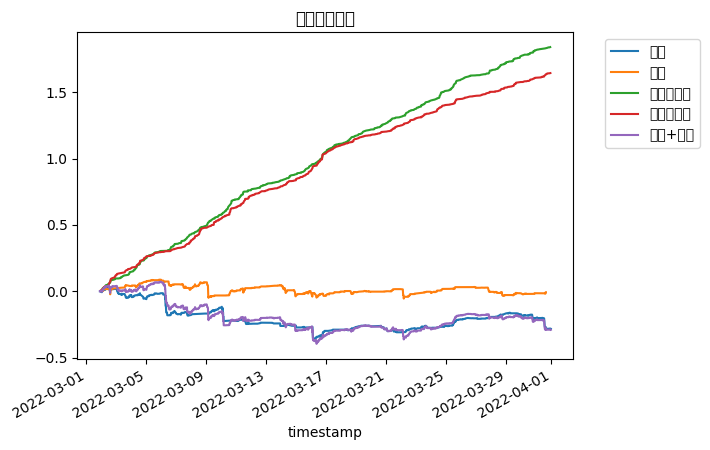

In [21]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
# model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
model.fit(df[features], df['y_sell'])

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
df[df['y_buy'] > 0]['y_buy'].cumsum().plot(label='理論値買い')
df[df['y_sell'] > 0]['y_sell'].cumsum().plot(label='理論値売り')

(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_fit.pkl')

In [22]:
from scipy.stats import ttest_1samp

C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

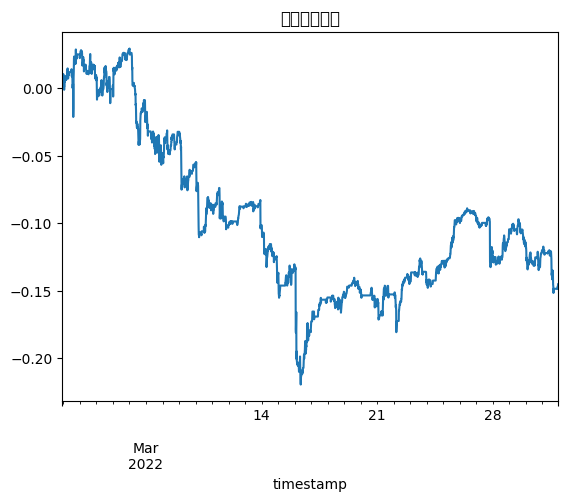

C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


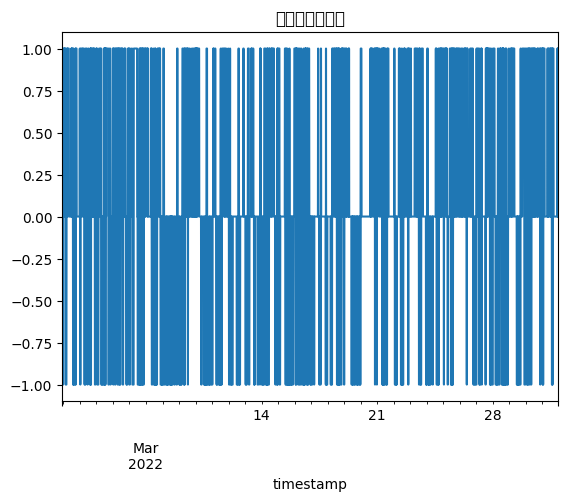

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-

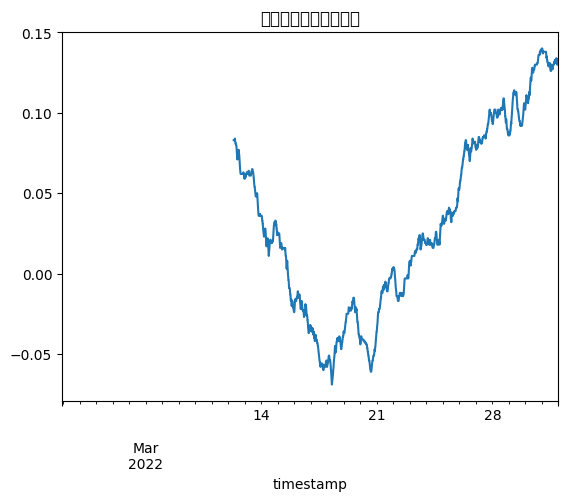

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-

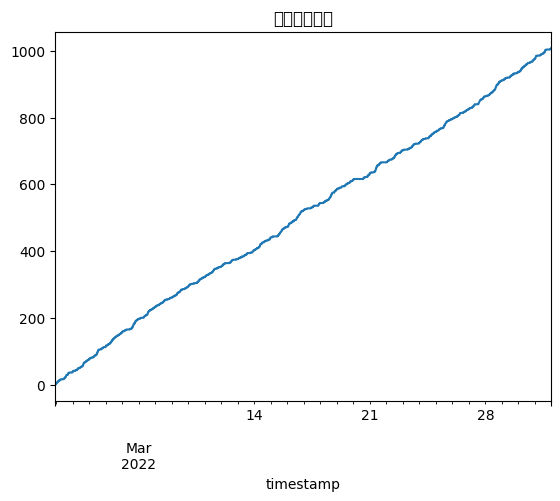

In [23]:
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()
